In [1]:
from z3 import *
import numpy as np
from itertools import product
from skimage.morphology import label
from scipy.ndimage import measurements
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display
import time
import warnings
warnings.filterwarnings("ignore", message="Please use `label` from the `scipy.ndimage` namespace")
warnings.filterwarnings("ignore", message="Please use `sum` from the `scipy.ndimage` namespace")

In [2]:
import numpy as np

In [3]:
grid = np.array([[  0,  0,  0,  0,  5,  0,  0,  0,  0],
                 [  0,  0,  0,  4,  0,  0,  0,  0,  0],
                 [  0,  0,  0,  0,  0,  0,  0,  0,  0],
                 [  0,  0,  0,  0,  0,  0,  0,  0,  0],
                 [  0,  0,  0,  0,  1,  0,  0,  0,  0],
                 [  0,  0,  0,  0,  0,  0,  0,  0,  0],
                 [  0,  0,  0,  0,  0,  0,  0,  0,  0],
                 [  0,  0,  0,  0,  0,  8,  0,  0,  0],
                 [  0,  0,  0,  0,  9,  0,  0,  0,  0]], dtype=int)

In [4]:
#grid = np.array([[  0,  0,  0,  0,  0,  0,  0,  0,  0],
#                 [  0,  0,  0,  0,  0,  0,  0,  0,  0],
#                 [  0,  0,  0,  0,  0,  0,  0,  0,  0],
#                 [  0,  0,  0,  0,  0,  0,  0,  0,  0],
#                 [  0,  0,  0,  0,  0,  0,  0,  0,  0],
#                 [  0,  0,  0,  0,  0,  0,  0,  0,  0],
#                 [  0,  0,  0,  0,  0,  0,  0,  0,  0],
#                 [  0,  0,  0,  0,  0,  0,  0,  0,  0],
#                 [  0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=int)

In [5]:
def make_hooks(n: int) -> np.ndarray:
    matrix = np.ones((n, n), dtype=int) * (2*n -1)
    matrix[1:,1:] = 0
    return [np.rot90(matrix, i) for i in range(4)]

hook_17, hook_15, hook_13, hook_11, hook_9, hook_7, hook_5, hook_3 = \
    make_hooks(9), make_hooks(8), make_hooks(7), make_hooks(6), make_hooks(5), make_hooks(4), make_hooks(3), make_hooks(2)
    
orthagonal = lambda i, j, N: [(i+di, j+dj) for (di,dj) in [(0,1),(1,0),(0,-1),(-1,0)] if 0<=i+di<N and 0<=j+dj<N]

def hook_constraint(hook_number: int, board: np.ndarray, N: int) -> PbEq:
    hook = dict[int, list]({17: hook_17, 15: hook_15, 13: hook_13, 11: hook_11, 9: hook_9, 7: hook_7, 5: hook_5, 3: hook_3}).get(hook_number)
    shift = N+1 - (hook_number + 1) // 2
    conditions = list[And]()
    for shift_i, shift_j, h in product(range(shift), range(shift), hook):
        conditions.append(And([board[i+shift_i][j+shift_j]==e for (i,j),e in np.ndenumerate(h) if e]))
    return PbEq([(cond, 1) for cond in conditions], 1)

In [6]:

start = time.time()
N = len(grid)
s = Solver()
Y = np.array(IntVector("y", N**2), dtype=object).reshape((N,N)) # This is for the actual values
X = np.array(IntVector("x", N**2), dtype=object).reshape((N,N)) # Y is for the L-stuff

# Adding the givens
s += [X[i][j]==e for (i,j),e in np.ndenumerate(grid) if e!=0]

#last_row = grid.shape[0] - 1
#s.add(X[last_row][0] == 0)

s += [Implies(X[i][j]!=0, Or([X[ni][nj]!=0 for (ni,nj) in orthagonal(i, j, N)])) 
      for (i,j),_ in np.ndenumerate(X)]

# Why am I adding my own 2*2 logic
s += [
    Or(X[i][j] == 0,
       X[i+1][j] == 0,
       X[i][j+1] == 0,
       X[i+1][j+1] == 0)
    for i in range(N-1) for j in range(N-1)
]
#
#

s += [And(val >= 0, val <= 9) for val in X.ravel()] # I assume this is the 0 to 9 constraint
s += [And(val >= 1, val <= 17) for val in Y.ravel()] # I assume this is the length
# s += Or([val==1 for val in Y.ravel()]) # I assume this garentees one 1

# This makes it such that there are 9 9s, 8 8s, etc
s += [PbEq([(X[i][j] == n, 1) for (i,j),_ in np.ndenumerate(X)], n) for n in range(1, N+1)] 


In [7]:
s += [PbEq([(X[i][j] == n, 1) for (i,j),_ in np.ndenumerate(X)], n) for n in range(1, N+1)]

for hook_number in [17, 15, 13, 11, 9, 7, 5, 3]:
    s += hook_constraint(hook_number=hook_number, board=Y, N=N)
    
s += [Implies(Y[i][j]==1, X[i][j]==1) for (i,j),_ in np.ndenumerate(grid)]
s += [Implies(Y[i][j]>3, X[i][j]!=2) for (i,j),_ in np.ndenumerate(grid)]
s += [X[i][j]<=Y[i][j] for (i,j),_ in np.ndenumerate(grid)]

X17, X15, X13, X11, X9, X7, X5, X3 = Ints("x17 x15 x13 x11 x9 x7 x5 x3")
s += Distinct([X17, X15, X13, X11, X9, X7, X5, X3])

y_to_x_mapping = dict[int, list]({17: X17, 15: X15, 13: X13, 11: X11, 9: X9, 7: X7, 5: X5, 3:X3})
for y_value, x_variable in y_to_x_mapping.items():
    s += [Implies(Y[i][j]==y_value, Or(X[i][j]==x_variable, X[i][j] == 0)) for (i,j),_ in np.ndenumerate(Y)]

In [8]:
col = 2  
s += [Or([
    And(
        X[row][col] == 3,
        And([X[r][col] == 0 for r in range(row+1, N)])
    )
    for row in range(N)
])]

col = 6
s += [Or([
    And(
        X[row][col] == 7,
        And([X[r][col] == 0 for r in range(0, row)])  
    )
    for row in range(N)
])]

row = 3
s += [Or([
    And(
        X[row][col] == 6,
        And([X[row][c] == 0 for c in range(col)]) if col > 0 else True
    )
    for col in range(N)
])]

row = 5
s += [Or([
    And(
        X[row][col] == 2,
        And([X[row][c] == 0 for c in range(col+1, N)]) if col < N-1 else True
    )
    for col in range(N)
])]

In [9]:
SHAPES = [
    [(0,1), (1,0), (1,1), (1,2), (2,0)],        # F
    [(0,0), (1,0), (2,0), (3,0), (4,0)],        # I
    [(0,0), (1,0), (2,0), (3,0), (3,1)],        # L
    [(0,0), (1,0), (2,0), (2,1), (3,1)],        # N
    [(0,0), (0,1), (1,0), (1,1), (2,0)],        # P
    [(0,0), (0,1), (0,2), (1,1), (2,1)],        # T
    [(0,0), (0,2), (1,0), (1,1), (1,2)],        # U
    [(0,0), (1,0), (2,0), (2,1), (2,2)],        # V
    [(0,0), (1,0), (1,1), (2,1), (2,2)],        # W
    [(0,1), (1,0), (1,1), (1,2), (2,1)],        # X
    [(0,0), (1,0), (2,0), (3,0), (2,1)],        # Y
    [(0,0), (1,0), (1,1), (1,2), (2,2)],        # Z
]

#SHAPES = [
#    [(0, 1), (1, 0), (1, 1), (1, 2), (2, 0)],  # F
#    [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0)],  # I
#    [(0, 0), (1, 0), (2, 0), (3, 0), (3, 1)],  # L
#    [(0, 0), (1, 0), (2, 0), (2, 1), (3, 1)],  # N
#    [(0, 0), (0, 1), (0, 2), (1, 1), (2, 1)],  # T
#    [(0, 0), (0, 2), (1, 0), (1, 1), (1, 2)],  # U
#    [(0, 0), (1, 0), (2, 0), (2, 1), (2, 2)],  # V
#    [(0, 0), (1, 0), (1, 1), (2, 1), (2, 2)],  # W
#    [(0, 1), (1, 0), (1, 1), (1, 2), (2, 1)],  # X
#    [(0, 0), (1, 0), (2, 0), (3, 0), (2, 1)],  # Y
#    [(0, 0), (0, 1), (1, 1), (2, 1), (2, 2)],  # Z1
#    [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)],  # I (vertical)
#]
#

In [10]:
SHAPE_INDEX = {
    "F": 0,
    "I": 1,
    "L": 2,
    "N": 3,
    "P": 4,
    "T": 5,
    "U": 6,
    "V": 7,
    "W": 8,
    "X": 9,
    "Y": 10,
    "Z": 11,
}

In [11]:
SHAPES[11]

[(0, 0), (1, 0), (1, 1), (1, 2), (2, 2)]

In [12]:
def rotate(shape):
    return [(c, -r) for r, c in shape]

def reflect(shape):
    return [(r, -c) for r, c in shape]

def normalize(shape):
    min_r = min(r for r,c in shape)
    min_c = min(c for r,c in shape)
    return sorted([(r-min_r, c-min_c) for r,c in shape])

def unique_transformations(shape):
    seen = set()
    results = []
    for s in [shape, reflect(shape)]:
        for _ in range(4):
            s = normalize(s)
            t = tuple(s)
            if t not in seen:
                seen.add(t)
                results.append(s)
            s = rotate(s)
    return results


In [13]:
#placements = []
#placement_vars = []
#for sid, base_shape in enumerate(SHAPES):
#    for shape in unique_transformations(base_shape):
#        for i in range(N):
#            for j in range(N):
#
#                if all(0 <= i+di < N and 0 <= j+dj < N for di,dj in shape):
#                    p = Bool(f"place_{sid}_{i}_{j}_{hash(tuple(shape))}")
#                    placements.append((p, sid, shape, i, j))
#                    placement_vars.append(p)

In [14]:
#for sid in range(len(SHAPES)):
#    # all placements that correspond to this shape
#    shape_placements = [p for (p, sid2, _, _, _) in placements if sid2 == sid]
#    # at most one placement can be chosen
#    s += PbLe([(p, 1) for p in shape_placements], 1)

In [15]:
#cell_coverings = {
#    (i, j): [p for p, _, shape, pi, pj in placements if (i - pi, j - pj) in shape]
#    for i in range(N) for j in range(N)
#}

In [16]:
#for i in range(N):
#    for j in range(N):
#        covering = cell_coverings[(i,j)]
#        if covering:
#            s += [
#                Implies(X[i][j] != 0, And(AtMost(*covering, 1), AtLeast(*covering, 1))),
#                Implies(X[i][j] == 0, Not(Or(covering)))
#            ]
#        else:
#            s += [X[i][j] == 0] 

In [17]:
#for sid in range(len(SHAPES)):
#    # Collect all placement Booleans for this shape
#    shape_placements = [p for p, s, _, _, _ in placements if s == sid]
#    
#    # Add constraint: at most one placement can be True
#    if shape_placements:
#        s.add(AtMost(*shape_placements, 1))

In [18]:
# Indices of SHAPES that must appear exactly once
exactly_once_shapes = [1, 3, 11, 5, 9, 7]  # e.g., L and X must appear exactly once

# Indices of SHAPES that may appear at most once
at_most_once_shapes = [0, 2, 4, 6, 8, 10]  # rest of the shapes

In [19]:
## Exactly once shapes
#for sid in exactly_once_shapes:
#    shape_placements = [p for p, s, _, _, _ in placements if s == sid]
#    # At least one
#    s.add(Or(shape_placements))
#    # At most one
#    for i in range(len(shape_placements)):
#        for j in range(i+1, len(shape_placements)):
#            s.add(Or(Not(shape_placements[i]), Not(shape_placements[j])))
#
## At most once shapes
#for sid in at_most_once_shapes:
#    shape_placements = [p for p, s, _, _, _ in placements if s == sid]
#    # Only at most one (may not appear at all)
#    for i in range(len(shape_placements)):
#        for j in range(i+1, len(shape_placements)):
#            s.add(Or(Not(shape_placements[i]), Not(shape_placements[j])))

In [20]:
from collections import defaultdict

placements = []         # list of dicts: {var, sid, shape, i, j, cells, mask}
placement_vars = []     # list of Bool Z3 vars (same order as placements)
cell_coverings = defaultdict(list)   # (i,j) -> list of placement Bool vars


def normalize(shape):
    """Return a canonical, sorted tuple of offsets with min coords shifted to (0,0)."""
    # shape: iterable of (di,dj)
    min_i = min(di for di,dj in shape)
    min_j = min(dj for di,dj in shape)
    return tuple(sorted(((di - min_i, dj - min_j) for di,dj in shape)))

for sid, base_shape in enumerate(SHAPES):
    seen = set()            # avoid duplicate transformed shapes for this base_shape
    for trans_idx, shape in enumerate(unique_transformations(base_shape)):
        norm = normalize(shape)
        if norm in seen:
            continue
        seen.add(norm)

        # compute bounding box of the normalized shape
        height = max(di for di,dj in norm) + 1
        width  = max(dj for di,dj in norm) + 1

        # only iterate top-left positions that allow the shape to fully fit
        for i0 in range(0, N - height + 1):
            for j0 in range(0, N - width + 1):
                cells = [(i0 + di, j0 + dj) for di,dj in norm]

                idx = len(placements)
                p = Bool(f"p_{idx}")     # short deterministic name (faster than hashing)
                # optional: integer bitmask of the covered cells (python int)
                mask = 0
                for (ci, cj) in cells:
                    mask |= 1 << (ci * N + cj)

                placements.append({
                    'var': p,
                    'sid': sid,
                    'shape': norm,
                    'i': i0,
                    'j': j0,
                    'cells': cells,
                    'mask': mask
                })
                placement_vars.append(p)

                # register this placement under every covered cell (fast incremental build)
                for (ci, cj) in cells:
                    cell_coverings[(ci, cj)].append(p)

for i, j in product(range(N), range(N)):
    covering = cell_coverings.get((i, j), [])
    if covering:
        # If cell is non-zero: exactly one placement covers it
        s.add(Implies(X[i][j] != 0, PbEq([(p, 1) for p in covering], 1)))
        # If cell is zero: none of the placements that would cover it can be present
        s.add(Implies(X[i][j] == 0, Not(Or(*covering))))
    else:
        s.add(X[i][j] == 0)

placements_by_shape = defaultdict(list)

for placement in placements:
    sid = placement['sid']      # which base shape it comes from
    p = placement['var']        # the Bool variable for this placement
    placements_by_shape[sid].append(p)

for sid, vars in placements_by_shape.items():
    s.add(PbLe([(p, 1) for p in vars], 1))

In [21]:
#Z_SID = 13  # index of Z in your SHAPES list
#bottom_row = 0  # adjust if your bottom row is different
#
## z_placements: list of (BoolVar, cells)
#z_placements = [(p['var'], p['cells']) for p in placements if p['sid'] == Z_SID]
#
#first_nonzero_constraints = []
#
#for i in range(N):         # rows bottom → top
#    for j in range(N):     # columns left → right
#        # cell (i,j) is covered by some Z placement
#        z_cover = Or([p for p, cells in z_placements if (i,j) in cells])
#
#        # all cells before (i,j) are empty
#        previous_empty = []
#        for ii in range(i+1):       # rows 0..i
#            jj_max = j if ii == i else N-1
#            for jj in range(jj_max + 1):
#                previous_empty.append(X[ii][jj] == 0)
#        
#        first_nonzero_constraints.append(And(z_cover, And(previous_empty)))
#
## Enforce that the first non-zero cell is covered by Z
#s.add(Or(first_nonzero_constraints))
#

In [22]:
## Index of X shape in SHAPES
#L_id = 11
#
## Collect all placement variables corresponding to X shapes
#X_placements = [p for p, sid, shape, pi, pj in placements if sid == L_id]
#
## Add constraint: at least one X is placed
#s.add(Or(X_placements))
#
## Index of X shape in SHAPES
#L_id = 6
#
## Collect all placement variables corresponding to X shapes
#X_placements = [p for p, sid, shape, pi, pj in placements if sid == L_id]
#
## Add constraint: at least one X is placed
#s.add(Or(X_placements))

In [23]:
def first_seen_in_row_left_to_right_allow_empty_after(placements, X, row, shape_id, N):
    """
    Enforces that the first occurrence of shape_id from left to right
    in the row covers a cell, all cells to the left of it are empty,
    but allows empty cells after it.
    """

    clauses = []

    for j in range(N):
        # all placements of the target shape covering this cell
        covering_shape = [p['var'] for p in placements
                          if p['sid'] == shape_id and (row, j) in p['cells']]
        if covering_shape:
            # this is a candidate for the first shape from the left
            # require one of these placements to cover this cell
            shape_clause = PbEq([(p, 1) for p in covering_shape], 1)

            # all cells to the left of j must be empty
            left_empty = []
            for jj in range(0, j):
                covering_left = [p['var'] for p in placements if (row, jj) in p['cells']]
                if covering_left:
                    left_empty.append(And([Not(p) for p in covering_left]))
            if left_empty:
                shape_clause = And(shape_clause, And(*left_empty))

            clauses.append(shape_clause)

    return [Or(clauses)]


Z_SID = SHAPE_INDEX['Z']    # or whichever index is your Z shape
row = 8      # row to enforce
N = len(X[0])

clauses = first_seen_in_row_left_to_right_allow_empty_after(placements, X, row, Z_SID, N)
for c in clauses:
    s.add(c)

Z_SID = SHAPE_INDEX['I']   # or whichever index is your Z shape
row = 0      # row to enforce
N = len(X[0])

clauses = first_seen_in_row_left_to_right_allow_empty_after(placements, X, row, Z_SID, N)
for c in clauses:
    s.add(c)

Z_SID =  SHAPE_INDEX['N'] 
row = 5      
N = len(X[0])

clauses = first_seen_in_row_left_to_right_allow_empty_after(placements, X, row, Z_SID, N)
for c in clauses:
    s.add(c)

In [24]:
SHAPE_INDEX['Z']

11

In [25]:
def first_seen_in_row_right_to_left_allow_empty_before(placements, X, row, shape_id, N):
    """
    Enforces that the first occurrence of shape_id from right to left
    in the row covers a cell, all cells to the right of it are empty,
    but allows empty cells before it.
    """

    clauses = []

    for j in reversed(range(N)):
        # all placements of the target shape covering this cell
        covering_shape = [p['var'] for p in placements
                          if p['sid'] == shape_id and (row, j) in p['cells']]
        if covering_shape:
            # this is a candidate for the first shape from the right
            # require one of these placements to cover this cell
            shape_clause = PbEq([(p, 1) for p in covering_shape], 1)

            # all cells to the right of j must be empty
            right_empty = []
            for jj in range(j + 1, N):
                covering_right = [p['var'] for p in placements if (row, jj) in p['cells']]
                if covering_right:
                    right_empty.append(And([Not(p) for p in covering_right]))
            if right_empty:
                shape_clause = And(shape_clause, And(*right_empty))

            clauses.append(shape_clause)

    return [Or(clauses)]


In [26]:
Z_SID = SHAPE_INDEX['V']    # index of Z shape
row = 8
N = len(X[0])

clauses = first_seen_in_row_right_to_left_allow_empty_before(placements, X, row, Z_SID, N)
for c in clauses:
    s.add(c)

Z_SID =  SHAPE_INDEX['X']    # index of Z shape
row = 3
N = len(X[0])

clauses = first_seen_in_row_right_to_left_allow_empty_before(placements, X, row, Z_SID, N)
for c in clauses:
    s.add(c)

Z_SID = SHAPE_INDEX['U']   # index of Z shape
row = 0
N = len(X[0])

clauses = first_seen_in_row_right_to_left_allow_empty_before(placements, X, row, Z_SID, N)
for c in clauses:
    s.add(c)

In [27]:
#for placement in placements:
#    p = placement['var']
#    shape = placement['shape']
#    i0 = placement['i']
#    j0 = placement['j']
#
#    # sum of cells covered by this placement that are non-zero
#    area = Sum([If(X[i0 + di][j0 + dj] != 0, 1, 0) for di, dj in shape])
#
#    # If placement is selected → area divisible by 2 OR 3 OR 5
#    s.add(Implies(p, Or(area % 2 == 0,
#                        area % 3 == 0,
#                        area % 5 == 0)))

In [28]:
# --- Connectivity enforcement ---
D = np.array(IntVector("d", N*N), dtype=object).reshape((N, N))
s += [And(D[i][j] >= 0, D[i][j] <= N*N) for i in range(N) for j in range(N)]

# root selector booleans
R = np.array(BoolVector("r", N*N), dtype=object).reshape((N, N))

# root must be filled
s += [Implies(R[i][j], X[i][j] != 0) for i in range(N) for j in range(N)]

# exactly one root
s += [PbEq([(R[i][j], 1) for i in range(N) for j in range(N)], 1)]

# root has distance 1
s += [Implies(R[i][j], D[i][j] == 1) for i in range(N) for j in range(N)]

# if empty → distance 0; if filled → 1..N*N
num_filled = Sum([If(X[i][j] != 0, 1, 0) for i in range(N) for j in range(N)])
for i in range(N):
    for j in range(N):
        s += [Implies(X[i][j] == 0, D[i][j] == 0),
              Implies(X[i][j] != 0, And(D[i][j] >= 1, D[i][j] <= num_filled))]

# neighbor helper
def neighbors(i, j):
    for di, dj in [(-1,0),(1,0),(0,-1),(0,1)]:
        ni, nj = i + di, j + dj
        if 0 <= ni < N and 0 <= nj < N:
            yield (ni, nj)

# connectivity: every non-root filled cell has a filled neighbor with smaller D
for i in range(N):
    for j in range(N):
        neigh_conds = [And(X[ni][nj] != 0, D[ni][nj] < D[i][j]) for (ni,nj) in neighbors(i,j)]
        s += [Implies(And(X[i][j] != 0, Not(R[i][j])), Or(*neigh_conds))]


In [29]:
def sol_print(numbers: np.ndarray, hooks: np.ndarray) -> None:
    _,ax = plt.subplots(1,1,figsize=(8,8))
    x = np.array((numbers).astype('int').astype('str'))
    x[x=="0"] = "-"
    ax = sns.heatmap(hooks,annot=x,cbar=False,cmap="tab10",fmt="",linewidths=0.25,annot_kws={"fontsize":12})
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()
    plt.show()


def sol_print2(grid: np.ndarray) -> None:
    """
    Plot a solution grid with shape IDs colored.
    grid: 2D array where 0 = empty, >0 = shape ID
    """
    annot = grid.astype(str)
    annot[grid == 0] = "-"  # show empty cells as '-'

    plt.figure(figsize=(8,8))
    sns.heatmap(grid, annot=annot, fmt="", cbar=False,
                cmap="tab20", linewidths=0.25, annot_kws={"fontsize":12})
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()

def areas(grid: np.ndarray) -> int:
    labels, num = measurements.label(np.logical_not(grid!=0))
    areas = measurements.sum(np.logical_not(grid>=1), labels, index=range(1, num+1))
    return int(np.prod(areas))

In [30]:
def sol_print2(grid: np.ndarray) -> None:
    """
    Plot a solution grid with shape IDs colored.
    grid: 2D array where 0 = empty, >0 = shape ID
    """
    annot = grid.astype(str)
    annot[grid == 0] = "-"  # show empty cells as '-'

    plt.figure(figsize=(8,8))
    sns.heatmap(grid, annot=annot, fmt="", cbar=False,
                cmap="tab20", linewidths=0.25, annot_kws={"fontsize":12})
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()

Time: 443.28378105163574 seconds
Shape 0 placed at (1,2), covers [(1, 3), (2, 2), (2, 3), (2, 4), (3, 4)]
Shape 1 placed at (0,1), covers [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
Shape 2 placed at (1,1), covers [(1, 1), (2, 1), (3, 1), (4, 1), (4, 2)]
Shape 3 placed at (4,0), covers [(4, 0), (5, 0), (6, 0), (6, 1), (7, 1)]
Shape 5 placed at (4,2), covers [(4, 4), (5, 2), (5, 3), (5, 4), (6, 4)]
Shape 6 placed at (0,6), covers [(0, 6), (0, 8), (1, 6), (1, 7), (1, 8)]
Shape 7 placed at (6,6), covers [(6, 8), (7, 8), (8, 6), (8, 7), (8, 8)]
Shape 9 placed at (2,6), covers [(2, 7), (3, 6), (3, 7), (3, 8), (4, 7)]
Shape 11 placed at (6,4), covers [(6, 6), (7, 4), (7, 5), (7, 6), (8, 4)]


## Total solve time of 447.856 seconds

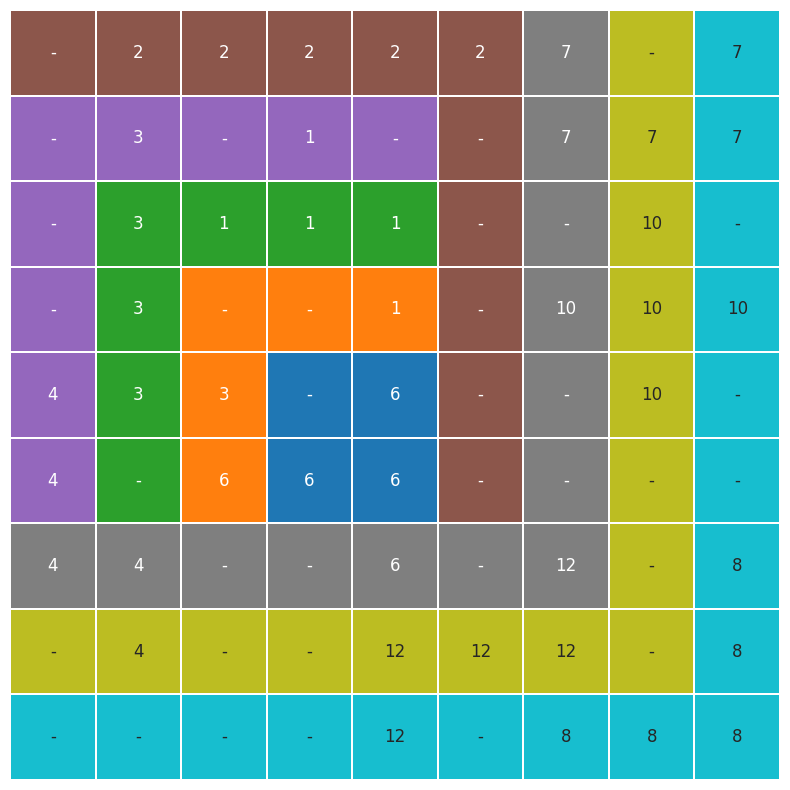

C:\Users\brian\AppData\Local\Temp\ipykernel_22072\3518616275.py:29: DeprecationWarning: Please import `label` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  labels, num = measurements.label(np.logical_not(grid!=0))
C:\Users\brian\AppData\Local\Temp\ipykernel_22072\3518616275.py:30: DeprecationWarning: Please import `sum` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  areas = measurements.sum(np.logical_not(grid>=1), labels, index=range(1, num+1))


## Answer is: 1,620

## Total solve time of 448.115 seconds

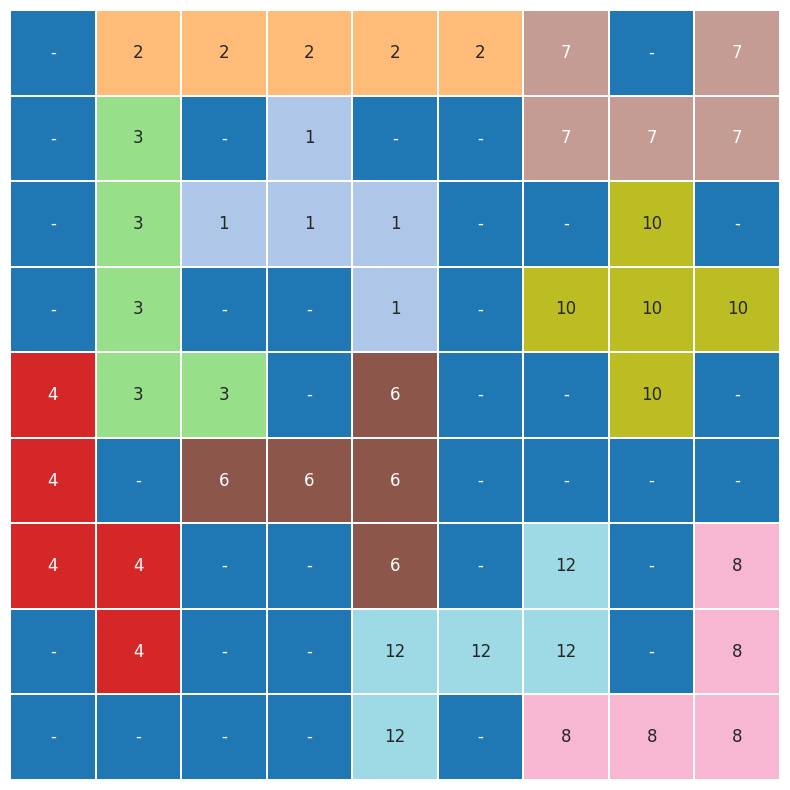

C:\Users\brian\AppData\Local\Temp\ipykernel_22072\3518616275.py:29: DeprecationWarning: Please import `label` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  labels, num = measurements.label(np.logical_not(grid!=0))
C:\Users\brian\AppData\Local\Temp\ipykernel_22072\3518616275.py:30: DeprecationWarning: Please import `sum` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  areas = measurements.sum(np.logical_not(grid>=1), labels, index=range(1, num+1))


## Answer is: 1,620

In [31]:
start2 = time.time()
if s.check():
    end = time.time()
    print("Time:", end - start2, "seconds")
    
    m = s.model()
    evalu = np.vectorize(lambda x: m.evaluate(x).as_long())
    # collect chosen placements
    chosen = [pinfo for pinfo in placements if m.evaluate(pinfo["var"], model_completion=True)]

    # Build grid with shape IDs (sid+1 so 0 = empty, >0 = shape)
    result_x = np.zeros((N, N), dtype=int)
    for pinfo in chosen:
        sid = pinfo["sid"]
        for (ci, cj) in pinfo["cells"]:
            result_x[ci, cj] = sid + 1

    # --- Print chosen placements / shapes ---
    for pinfo in chosen:
        sid = pinfo["sid"]
        i0, j0 = pinfo["i"], pinfo["j"]
        cells = pinfo["cells"]
        print(f"Shape {sid} placed at ({i0},{j0}), covers {cells}")

    # --- Connectivity check (optional) ---
    # If you want to enforce connectivity, replace `True` with an actual check:
    # if np.max(label(result_x != 0, connectivity=1)) == 1:
    if np.max(label(result_x!= 0, connectivity=1)) == 1:
        display(Markdown('## Total solve time of {:.3f} seconds'.format(time.time()-start)))
        sol_print(numbers=result_x, hooks=evalu(Y))
        display(Markdown('## Answer is: {:,.0f}'.format(areas(result_x))))
        
    if np.max(label(result_x!= 0, connectivity=1)) == 1:
        display(Markdown('## Total solve time of {:.3f} seconds'.format(time.time()-start)))
        sol_print2(result_x)  # colored plot 
        display(Markdown('## Answer is: {:,.0f}'.format(areas(result_x))))
else:
    display(Markdown('**No solution found.**'))
    

In [32]:
np.max(label(result_x!= 0, connectivity=1))

1

In [33]:
grid = np.array([[  5,  5,  5,  5,  5,  0,  7,  0,  9],
                 [  0,  4,  0,  4,  0,  0,  7,  8,  9],
                 [  0,  6,  6,  6,  6,  0,  0,  8,  0],
                 [  0,  6,  0,  0,  3,  0,  7,  8,  9],
                 [  4,  6,  3,  0,  1,  0,  0,  8,  0],
                 [  4,  0,  3,  2,  2,  0,  0,  0,  0],
                 [  7,  7,  0,  0,  7,  0,  7,  0,  9],
                 [  0,  8,  0,  0,  8,  8,  8,  0,  9],
                 [  0,  0,  0,  0,  9,  0,  9,  9,  9]], dtype=int)

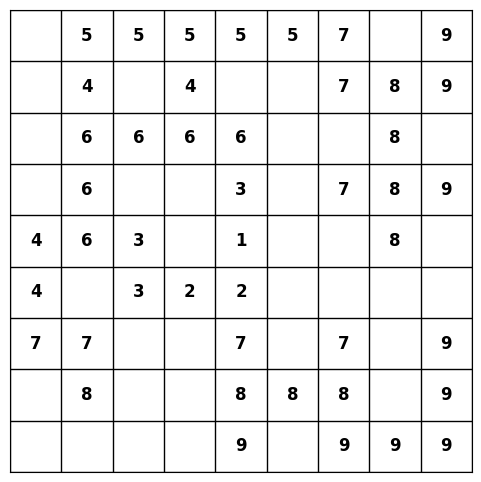

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

grid = np.array([[  0,  5,  5,  5,  5,  5,  7,  0,  9],
                 [  0,  4,  0,  4,  0,  0,  7,  8,  9],
                 [  0,  6,  6,  6,  6,  0,  0,  8,  0],
                 [  0,  6,  0,  0,  3,  0,  7,  8,  9],
                 [  4,  6,  3,  0,  1,  0,  0,  8,  0],
                 [  4,  0,  3,  2,  2,  0,  0,  0,  0],
                 [  7,  7,  0,  0,  7,  0,  7,  0,  9],
                 [  0,  8,  0,  0,  8,  8,  8,  0,  9],
                 [  0,  0,  0,  0,  9,  0,  9,  9,  9]], dtype=int)

fig, ax = plt.subplots(figsize=(6, 6))

# Draw empty grid (white background)
ax.imshow(np.ones_like(grid), cmap="gray", vmin=0, vmax=1)

# Add grid lines
ax.set_xticks(np.arange(-0.5, grid.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5, grid.shape[0], 1), minor=True)
ax.grid(which="minor", color="black", linestyle="-", linewidth=1)

# Remove axis ticks
ax.tick_params(which="both", bottom=False, left=False, labelbottom=False, labelleft=False)

# Add numbers in cells
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        if grid[i, j] != 0:  # only show nonzero numbers
            ax.text(j, i, str(grid[i, j]),
                    ha='center', va='center', fontsize=12, fontweight='bold')

plt.show()



In [35]:
thfcgjhvfguj

NameError: name 'thfcgjhvfguj' is not defined

In [ ]:
9*15*3*4

1620

In [ ]:
if s.check():
    m = s.model()
    evalu = np.vectorize(lambda x: m.evaluate(x).as_long())
    result_x = np.array([[m.evaluate(X[i][j]).as_long() for j in range(N)] for i in range(N)])
    
    # Connectivity check
    if np.max(label(result_x != 0, connectivity=1)) == 1:
        display(Markdown('## Total solve time of {:.3f} seconds'.format(time.time()-start)))
        sol_print(numbers=result_x, hooks=evalu(Y))
        display(Markdown('## Answer is: {:,.0f}'.format(areas(result_x))))
else:
    display(Markdown('**No solution found.**'))

## Total solve time of 7536.920 seconds

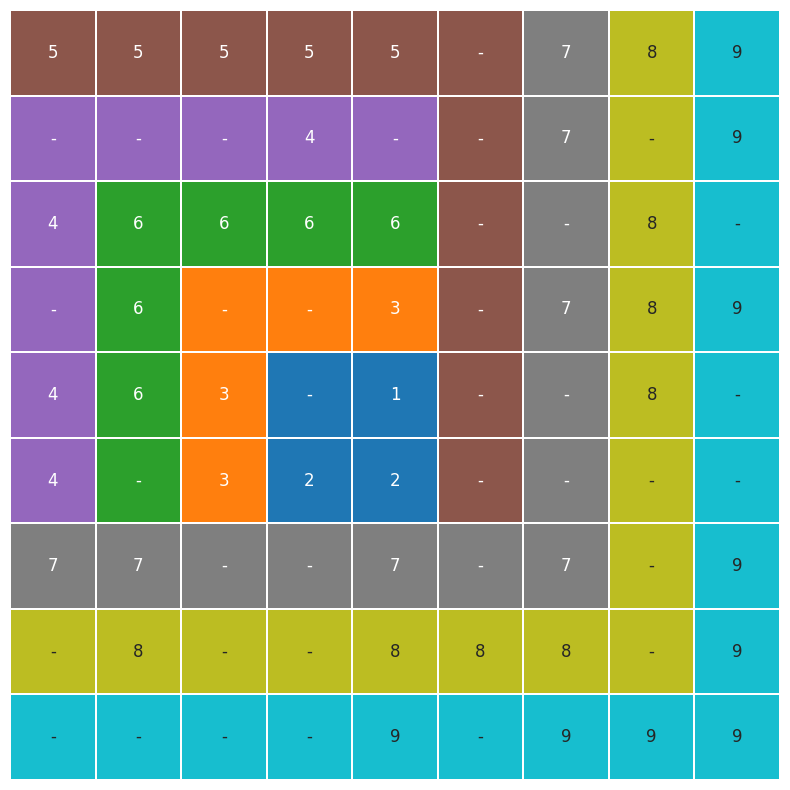

C:\Users\brian\AppData\Local\Temp\ipykernel_30632\2877243823.py:12: DeprecationWarning: Please import `label` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  labels, num = measurements.label(np.logical_not(grid!=0))
C:\Users\brian\AppData\Local\Temp\ipykernel_30632\2877243823.py:13: DeprecationWarning: Please import `sum` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  areas = measurements.sum(np.logical_not(grid>=1), labels, index=range(1, num+1))


## Answer is: 1,296

In [ ]:
if True:
    m = s.model()
    evalu = np.vectorize(lambda x: m.evaluate(x).as_long())
    result_x = np.array([[m.evaluate(X[i][j]).as_long() for j in range(N)] for i in range(N)])
    
    # Connectivity check
    if True:
        display(Markdown('## Total solve time of {:.3f} seconds'.format(time.time()-start)))
        sol_print(numbers=result_x, hooks=evalu(Y))
        display(Markdown('## Answer is: {:,.0f}'.format(areas(result_x))))
else:
    display(Markdown('**No solution found.**'))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches

def sol_print_combined(numbers: np.ndarray, hooks: np.ndarray) -> None:
    """
    Plot a solution grid:
      - Shapes are filled with colors (based on shape ID).
      - Numbers are shown as text annotations.
      - L-shaped hooks are drawn as outlines, not colors.

    Args:
        numbers: 2D numpy array of integers, cell numbers (0 = empty).
        hooks: 2D numpy array of same shape, with 1 for hook cells, 0 otherwise.
    """
    n, m = numbers.shape
    annot = numbers.astype(str)
    annot[numbers == 0] = "-"  # empty cells as "-"

    plt.figure(figsize=(8,8))

    # Draw shapes (from numbers>0)
    sns.heatmap(numbers, annot=annot, fmt="", cbar=False,
                cmap="tab20", linewidths=0.25,
                annot_kws={"fontsize":12}, alpha=0.9)

    ax = plt.gca()

    # Overlay hook outlines
    for i in range(n):
        for j in range(m):
            if hooks[i, j] != 0:
                # Draw a thin rectangle around the hook cell
                rect = patches.Rectangle((j, i), 1, 1, fill=False,
                                         edgecolor="black", linewidth=2)
                ax.add_patch(rect)

    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()


Time: 74.87990927696228 seconds
Shape 0 placed at (1,2), covers [(1, 3), (2, 2), (2, 3), (2, 4), (3, 4)]
Shape 2 placed at (1,1), covers [(1, 1), (2, 1), (3, 1), (4, 1), (4, 2)]
Shape 3 placed at (4,0), covers [(4, 0), (5, 0), (6, 0), (6, 1), (7, 1)]
Shape 4 placed at (4,2), covers [(4, 4), (5, 2), (5, 3), (5, 4), (6, 4)]
Shape 5 placed at (0,6), covers [(0, 6), (0, 8), (1, 6), (1, 7), (1, 8)]
Shape 6 placed at (6,6), covers [(6, 8), (7, 8), (8, 6), (8, 7), (8, 8)]
Shape 8 placed at (2,6), covers [(2, 7), (3, 6), (3, 7), (3, 8), (4, 7)]
Shape 10 placed at (6,4), covers [(6, 6), (7, 4), (7, 5), (7, 6), (8, 4)]
Shape 11 placed at (0,1), covers [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]


## Total solve time of 8249.107 seconds

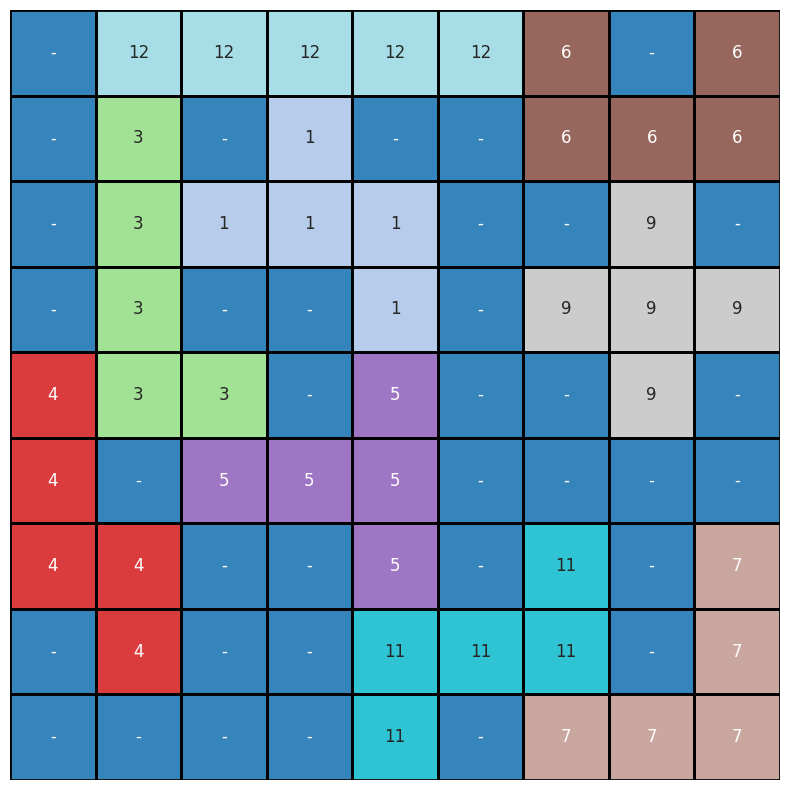

C:\Users\brian\AppData\Local\Temp\ipykernel_30632\2877243823.py:12: DeprecationWarning: Please import `label` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  labels, num = measurements.label(np.logical_not(grid!=0))
C:\Users\brian\AppData\Local\Temp\ipykernel_30632\2877243823.py:13: DeprecationWarning: Please import `sum` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  areas = measurements.sum(np.logical_not(grid>=1), labels, index=range(1, num+1))


## Answer is: 1,620

In [ ]:
start2 = time.time()
if s.check():
    end = time.time()
    print("Time:", end - start2, "seconds")

    m = s.model()
    evalu = np.vectorize(lambda x: m.evaluate(x).as_long())
    # collect chosen placements
    chosen = [pinfo for pinfo in placements if m.evaluate(pinfo["var"], model_completion=True)]

    # Build grid with shape IDs (sid+1 so 0 = empty, >0 = shape)
    result_x = np.zeros((N, N), dtype=int)
    for pinfo in chosen:
        sid = pinfo["sid"]
        for (ci, cj) in pinfo["cells"]:
            result_x[ci, cj] = sid + 1

    # --- Print chosen placements / shapes ---
    for pinfo in chosen:
        sid = pinfo["sid"]
        i0, j0 = pinfo["i"], pinfo["j"]
        cells = pinfo["cells"]
        print(f"Shape {sid} placed at ({i0},{j0}), covers {cells}")

    # --- Connectivity check (optional) ---
    if True:
        display(Markdown('## Total solve time of {:.3f} seconds'.format(time.time()-start)))
        
        # Use combined visualization
        sol_print_combined(numbers=result_x, hooks=evalu(Y))

        display(Markdown('## Answer is: {:,.0f}'.format(areas(result_x))))
else:
    display(Markdown('**No solution found.**'))


In [ ]:
def sol_print2(grid: np.ndarray) -> None:
    """
    Plot a solution grid with shape IDs colored.
    grid: 2D array where 0 = empty, >0 = shape ID
    """
    annot = grid.astype(str)
    annot[grid == 0] = "-"  # show empty cells as '-'

    plt.figure(figsize=(8,8))
    sns.heatmap(grid, annot=annot, fmt="", cbar=False,
                cmap="tab20", linewidths=0.25, annot_kws={"fontsize":12})
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()

    # Assume N x N grid
grid = np.zeros((N, N), dtype=int)

# Fill grid from placement variables
for p, sid, shape, pi, pj in placements:
    if m.evaluate(p):  # check if this placement is selected in the solution
        for di, dj in shape:
            grid[pi + di, pj + dj] = sid + 1  # +1 so empty cells are 0

# Plot
sol_print2(grid)

ValueError: too many values to unpack (expected 5)

In [ ]:
# Assume N x N grid
grid = np.zeros((N, N), dtype=int)

# Fill grid from placement variables
for p, sid, shape, pi, pj in placements:
    if m.evaluate(p):  # check if this placement is selected in the solution
        for di, dj in shape:
            grid[pi + di, pj + dj] = sid + 1  # +1 so empty cells are 0

# Plot
sol_print2(grid)

ValueError: too many values to unpack (expected 5)

In [ ]:
display(Markdown('## Total solve time of {:.3f} seconds'.format(time.time()-start)))
sol_print(numbers=result_x, hooks=evalu(Y))
display(Markdown('## Answer is: {:,.0f}'.format((areas(result_x)))))

## Total solve time of 324.356 seconds

NameError: name 'evalu' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def sol_print2(grid: np.ndarray) -> None:
    """
    Plot a solution grid with shape IDs colored distinctly.
    grid: 2D array where 0 = empty, >0 = shape ID
    """
    annot = grid.astype(str)
    annot[grid == 0] = ""  # show empty cells as blank

    plt.figure(figsize=(8, 8))

    # Make a color palette with enough distinct colors (skip index 0 for empty)
    max_id = int(grid.max())
    palette = sns.color_palette("tab20", max_id)  # repeatable colors
    cmap = sns.color_palette(["white"] + palette)  # white for empty (0)

    sns.heatmap(
        grid,
        annot=annot,
        fmt="",
        cbar=False,
        cmap=cmap,
        linewidths=0.5,
        linecolor="black",
        square=True,
        xticklabels=False,
        yticklabels=False,
        annot_kws={"fontsize": 12, "weight": "bold", "color": "black"},
    )

    plt.tight_layout()
    plt.show()
